# Preprocessing of cardiac data
This is a notebook to conduct preprocessing of the raw data of the public cardiac MRI dataset used for PISCO evaluation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from pathlib import Path
import yaml
import io
import re

In [3]:
# Get the directory where the current notebook is located
notebook_dir = os.getcwd()  # Use this to find the current working directory in Jupyter
# Append the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)

# Define paths and load raw data
The raw data folder should contain the .mat files with the raw k-space data. The raw data can be downloaded here: 
[1] El-Rewaidy, Hossam, 2020, "Replication Data for: Multi-Domain Convolutional Neural Network (MD-CNN) For Radial Reconstruction of Dynamic Cardiac MRI", https://doi.org/10.7910/DVN/CI3WB6, Harvard Dataverse, V2

https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi%3A10.7910%2FDVN%2FCI3WB6&version=2.0&q=&fileTypeGroupFacet=%22Data%22&fileAccess=&fileTag=&fileSortField=&fileSortOrder=&tagPresort=false&folderPresort=true

The processed data folder will store the preprocessed data in .npy format.

In [4]:
## Define paths of raw and processed data
base_path = notebook_dir
raw_path = 'raw'
processed_path = 'processed'
print(base_path)

/home/iml/veronika.spieker/workspace/PISCO-priv/dummy_data


In [5]:
from datasets.preprocess.preloader_cardiac import DataLoader
from datasets.utils_cardiac import find_subject_file

BART toolbox not setup properly or not available


In [6]:
# Search for all downloaded .mat files in the raw data folder
pattern = r'P(\d+)_'
# List to store extracted subject numbers
subject_numbers = []
# Loop through all files in the directory
for root, dirs, files in os.walk(os.path.join(base_path, raw_path)):
    for file in files:
        if file.endswith(".mat"):  # Check if the file is a .mat file
            # Match the regex pattern on the file name
            match = re.search(pattern, file)
            if match:
                subject_number = match.group(1)  # Extract the subject number
                subject_numbers.append(subject_number)

# Setup configuration for preprocessing
The configuration dictionary contains the following keys:
- gpu: GPU device if needed
- spoke_number: Number of desired spokes per frame in retrospectively undersampled radial acquisition
- subject_names: List of subject numbers to process (automatically extracted before)
- data_root: Path to the root folder containing raw data
- fe_crop: Fraction of the readout to crop in the frequency encoding direction (to reverse zerofilling from original acquisition)
- oversample: Factor of oversampling with which k-space data was acquired (affects the final image size)
- nx/ny: Target image size in the x/y-direction (needs to be set to image size after cropping)
- n_tw: Number of neighboring time frames (relevant for golden angle calculation when undersampling, see [1] for details)

In [7]:
config = {
    "gpu": "cuda:0",  # GPU device if needed
    "spoke_number": 2, # R1: 196 spokes, R15: 14 spokes, R26: 8 spokes, R52: 4 spokes, R104: 2  spokes
    "subject_names": subject_numbers, # all subjects found in raw folder above
    "data_root": base_path,
    "fe_crop": 0.5,
    "oversample": 2,
    "nx": 208,
    "ny": 208,
    "n_tw": 7
}

In [11]:
raw_name = "raw"
if "acc_factor" not in config:
    config["acc_factor"] = np.int32(np.round(config["nx"] / config["spoke_number"]))
processed_name = "processed_pseudogolden_accfactor{}".format(config["acc_factor"])
reference_name = "ref"

raw_path = os.path.join(base_path,raw_name)
processed_path = os.path.join(base_path,processed_name)
reference_path = os.path.join(base_path,reference_name)

# Create a folder for processed data
os.makedirs(processed_path, exist_ok=True)

In [12]:
# Process each file in the folder
filenames = []
if config["subject_names"] is not None:
    for sub in config["subject_names"]:
        filenames.append(find_subject_file(raw_path, sub))
else:
    filenames = [os.path.splitext(filename)[0] for filename in os.listdir(raw_path)]
    config["subject_names"] = [int(filename.split("P")[1].split("_")[0]) for filename in filenames]

# Run data preprocessing
The following code will load the raw data, retrospectively undersample it, compute the sensitivity maps with ESPIRiT [2] and reference image and save the processed data.
The file in the processed folder will contain the relevant data for further NIK & PISCO training.


[2] M. Uecker et al., “ESPIRiT–an eigenvalue approach to autocalibrating
parallel MRI: where SENSE meets GRAPPA,” Magnetic Resonance
in Medicine, vol. 71, no. 3, pp. 990–1001, 2014, ISSN: 1522-2594.

FE steps after hermitian fill and zerocropping: 414


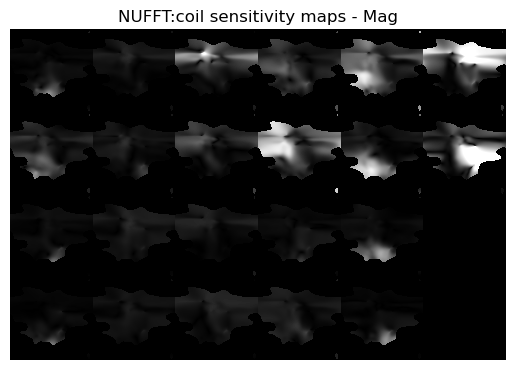

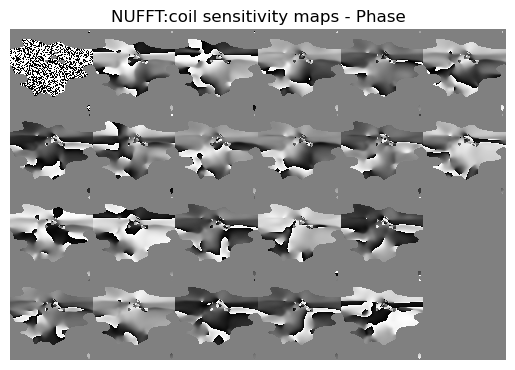

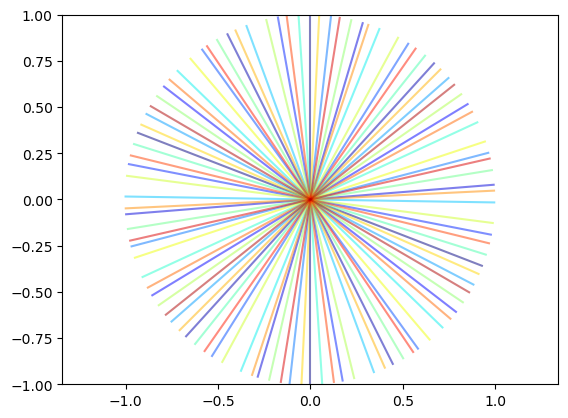

Retrospective Undersampling for 2 spokes per phased with pseudoangle 111.25°
Caution: Maximum value of trajectory is 0.9951691031455994
Caution: Maximum value of trajectory is 0.8938989043235779
Caution: Maximum value of trajectory is 0.9919748902320862
Caution: Maximum value of trajectory is 0.8510116338729858
Caution: Maximum value of trajectory is 0.9844969511032104
Caution: Maximum value of trajectory is 0.8426337242126465
Caution: Maximum value of trajectory is 0.9889116883277893
Caution: Maximum value of trajectory is 0.8823162317276001
Caution: Maximum value of trajectory is 0.9950412511825562
Caution: Maximum value of trajectory is 0.92243891954422
Caution: Maximum value of trajectory is 0.9979453682899475
Caution: Maximum value of trajectory is 0.9493757486343384
Caution: Maximum value of trajectory is 0.9824128150939941
Caution: Maximum value of trajectory is 0.9702181220054626
Caution: Maximum value of trajectory is 0.9712361693382263
Caution: Maximum value of trajectory is 

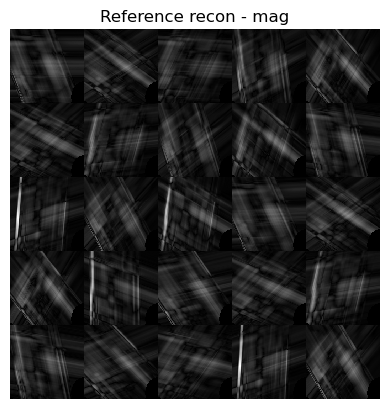

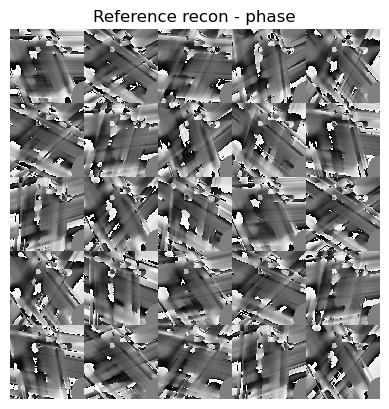

Processed data saved to: /home/iml/veronika.spieker/workspace/PISCO-priv/dummy_data/processed_pseudogolden_accfactor104/P10_slc1_phs25_lins196_cols832_cha22.npz


In [10]:
for sub, filename in zip(config["subject_names"],filenames):

    config['subject_name'] = sub
    dataloader = DataLoader(config)
    dataloader.load_raw_data()
    if config["acc_factor"] > 1:
        dataloader.retrospectiveUndersamplingPseudoGoldenAngle(spoke_number=config["spoke_number"])
    dataloader.compute_reference(reference_path)
    dataloader.save_processed_data(processed_path)

with io.open(processed_path + '/config.yml', 'w', encoding='utf8') as outfile:
    yaml.dump(config, outfile, default_flow_style=False, allow_unicode=True)

plt.close()
